In [17]:
import yfinance as yf
import numpy as np
import tensorflow as tf
import random
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [18]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
SYMBOL = 'DIS'
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
TIME_STEPS = 60
TRAIN_SPLIT = 0.5
EPOCHS = 50
BATCH_SIZE = 32

df = yf.download(symbol, start=start_date, end=end_date)

df.head()

C:\Users\gabri\AppData\Local\Temp\ipykernel_20616\3874391892.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,DIS,DIS,DIS,DIS,DIS
Date,,,,,
2014-01-02,68.577538,68.784343,68.244859,68.370739,5200900
2014-01-03,68.433685,68.964176,68.343772,68.604524,4060700
2014-01-06,68.172943,69.090065,67.876225,68.811333,6816200
2014-01-07,68.640495,68.964187,68.244877,68.442690,4494900
2014-01-08,67.633453,68.586542,67.264802,68.451669,10900300


In [19]:
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
prices = df[['Close']].values

scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

C:\Users\gabri\AppData\Local\Temp\ipykernel_20616\2419030301.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [20]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [21]:
X, y = create_sequences(prices_scaled, TIME_STEPS)

split_index = int(len(X) * TRAIN_SPLIT)

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [22]:
def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse'
    )
    return model

model = build_model((X_train.shape[1], 1))
model.summary()

C:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)

In [24]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0139 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0013 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0011 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.7804e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.9470e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.0474e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.7683e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.2699e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.0184e-04 - val_loss: 0.0012 - learning_rate: 0.

In [25]:
def evaluate_model(model, X, y, scaler):
    y_pred = model.predict(X)
    y_real = scaler.inverse_transform(y)
    y_pred_real = scaler.inverse_transform(y_pred)

    mae = mean_absolute_error(y_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred_real))
    mape = np.mean(np.abs((y_real - y_pred_real) / y_real)) * 100

    return mae, rmse, mape, y_real, y_pred_real

mae, rmse, mape, y_real, y_pred = evaluate_model(
    model, X_val, y_val, scaler
)

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MAE : 2.70
RMSE: 3.73
MAPE: 2.32%


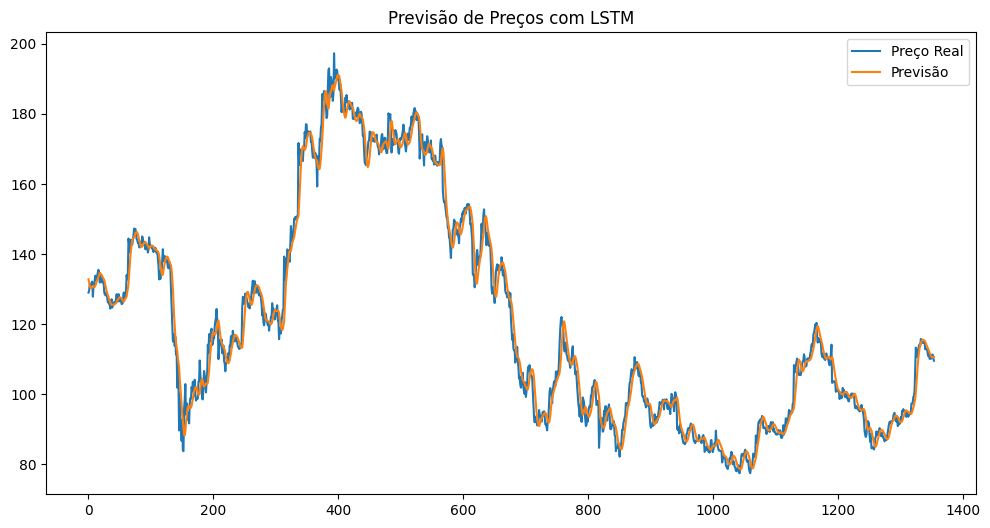

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_real, label='Preço Real')
plt.plot(y_pred, label='Previsão')
plt.title('Previsão de Preços com LSTM')
plt.legend()
plt.show()

In [27]:
model.save('modelo_lstm.h5')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']